* MNIST inverse network
* Newsgroups inverse network
* Squared error loss and classification loss
  * Also with L1 regularisation

In [96]:
import sys
import cPickle as pickle
import gzip
import random
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *
# ---
from scipy.io import loadmat
# ---
random.seed(0)
np.random.seed(0)

In [62]:
def print_net(out):
    for layer in get_all_layers(out):
        print layer.output_shape
    print count_params(out)

Load in the newsgroup dataset and add 100 random $U(0,1)$ (discrete) attributes to the end.

In [159]:
data = loadmat("../data/20news_w100.mat")
X_total = data["documents"].toarray().T
X_total = np.asarray(X_total, dtype="float32")
X_noise = np.asarray(np.random.randint(0, 2, (X_total.shape[0], X_total.shape[1])), dtype="float32")
X_total = np.hstack( (X_total, X_noise) )
y_total = data["newsgroups"]-1
y_total = np.asarray(y_total[0],dtype="int32")

In [160]:
def simple_mlp(X_data, y_data, lamb=0.0):
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_out = DenseLayer(a_in, num_units=np.max(y_data)+1, nonlinearity=softmax)   
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [161]:
mlp1 = simple_mlp(X_total, y_total, lamb=1e-4)

In [162]:
print_net(mlp1["net"])

(None, 200)
(None, 4)
804


In [163]:
def train_net(X_train, y_train, train_fn, num_epochs, batch_size, shuffle=True):
    idxs = [x for x in range(0, X_train.shape[0])]
    Xt, yt = X_train, y_train
    for epoch in range(0, num_epochs):
        if shuffle:
            random.shuffle(idxs)
            Xt = X_train[idxs]
            yt = y_train[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        print np.mean(losses)

In [143]:
def get_accuracy(X_train, y_train, predict_fn):
    return float(np.sum(np.argmax(predict_fn(X_train),axis=1) == y_train)) / len(y_train)

In [154]:
def get_mean_abs_grad(X_train, y_train, x_grad_fn):
    return np.mean(np.abs(x_grad_fn(X_train, y_train)),axis=0)

In [164]:
train_net(X_total, y_total, mlp1["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.23782492573
0.960639491297
0.848167788826
0.784305225545
0.743613367122
0.713672729464
0.691508968917
0.674317077775
0.660457236334
0.647527825989
0.63826223627
0.629079979089
0.621915280712
0.615667768524
0.60946658993
0.604178421548
0.599059228146
0.595081339638
0.591303508491
0.587313707409
0.584546975842
0.581150863592
0.578920502777
0.576257051497
0.573726568034
0.570987052064
0.569266816217
0.567626849824
0.565838529677
0.563938650743
0.562113950668
0.56032212932
0.559437404324
0.55771197196
0.557043260298
0.555486703026
0.554498902576
0.552672347261
0.552092306087
0.55127030752
0.550372989862
0.549320239056
0.548901000415
0.547335477268
0.546944026156
0.545982552765
0.545147662821
0.544118613568
0.543581190859
0.543280369104
0.542228214874
0.541875568586
0.541428510473
0.540986840894
0.54008416404
0.539583482373
0.539327911776
0.539311553776
0.538282317624
0.537281528075
0.537239494005
0.536886463901
0.536271668828
0.536607975535
0.535751097298
0.535342858907
0.534710173516
0.

In [165]:
get_accuracy(X_total, y_total, mlp1["predict_fn"])

0.8180642777983007

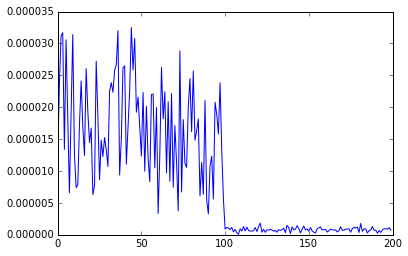

In [166]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp1["x_grad_fn"]) )

Ok, let's examine this in the context of an MLP.

In [304]:
def mlp(X_data, y_data, num_hidden_units=None, lamb=0.0):
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # hacky
    print a_hidden.output_shape
    z_hidden = InputLayer(a_hidden.output_shape, W=a_hidden.W)
    z_out = DenseLayer(z_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax, W=a_out.W)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    z_loss = categorical_crossentropy( get_output(z_out, X), y ).mean() + \
        lamb*regularize_layer_params(z_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    # the loss fn is defined in terms of X -> hidden -> out
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    # hacky
    hidden_grad_fn = theano.function([X, y], T.grad(z_loss, X))
    hidden_predict_fn = theano.function([X], get_output(a_hidden, X))
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "hidden_grad_fn":hidden_grad_fn,
            "hidden_predict_fn":hidden_predict_fn,
            "loss_fn": loss_fn}

In [230]:
mlp2 = mlp(X_total, y_total, lamb=1e-4)

(None, 100)


In [232]:
train_net(X_total, y_total, mlp2["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.19901941848
0.80897760697
0.652031093172
0.593974877305
0.565017012846
0.551322376491
0.537515358757
0.529481812419
0.523333190462
0.517985284556
0.514454321247
0.508864846068
0.504042333193
0.501687158622
0.497792434021
0.493968811041
0.491689533601
0.486200291181
0.483582250672
0.481528231983
0.47762103487
0.472464986878
0.469549716484
0.466590889793
0.463653685988
0.456291002157
0.453850043824
0.450046695938
0.445938526074
0.441542643846
0.437549192395
0.433138419964
0.42956714582
0.424302895376
0.420501219242
0.415909556831
0.409319371419
0.4077957623
0.402048293658
0.397617418716
0.392250389816
0.387710230799
0.383632947576
0.378012766043
0.374251000022
0.369855143134
0.365644248687
0.361564081911
0.355574970892
0.352051685288
0.347322243599
0.343366729663
0.338423631994
0.333707069676
0.329851023632
0.325194626334
0.320559384676
0.317959594831
0.312393026207
0.307730210612
0.302853843776
0.300316258339
0.295066695261
0.291609548663
0.287978236912
0.285015198948
0.281155894635
0

In [219]:
get_accuracy(X_total, y_total, mlp2["predict_fn"])

0.9999384312276813

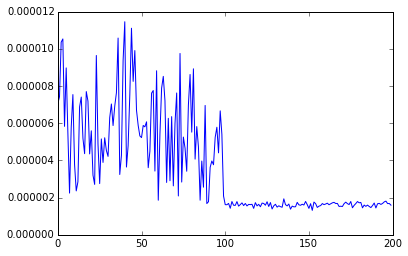

In [220]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp2["x_grad_fn"]) )

In [237]:
mlp2_hidden_grads = mlp2["hidden_grad_fn"](
    np.asarray(mlp2["hidden_predict_fn"](X_total), dtype="float32"),
    y_total
)

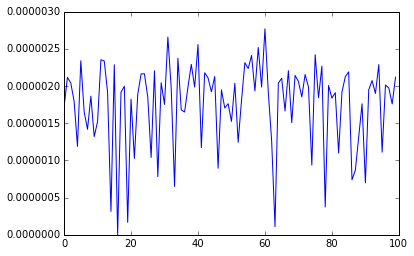

In [246]:
plt.plot( np.mean(np.abs(mlp2_hidden_grads), axis=0) )

Ok, could we maybe write some code to generate these graphs per epoch?

In [277]:
%%bash
mkdir -p feature_ranking_out/input_grads
mkdir -p feature_ranking_out/hidden_grads

In [378]:
mlp3 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)

(None, 100)


In [342]:
print_net(mlp3["net"])

(None, 200)
(None, 100)
(None, 4)
20504


Cut the data into training and validation.

In [283]:
X_total.shape, y_total.shape

((16242, 200), (16242,))

In [293]:
idxs = [x for x in range(0, X_train.shape[0])]
random.shuffle(idxs)
train_idxs = idxs[0 : int(0.75*len(idxs))]
valid_idxs = idxs[int(0.75*len(idxs)) :: ]
Xt, yt, Xv, yv = X_total[train_idxs], y_total[train_idxs], X_total[valid_idxs], y_total[valid_idxs]

In [294]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((12181, 200), (12181,), (4061, 200), (4061,))

In [377]:
def graph_grad_train(Xt, yt, Xv, yv, mlp, num_epochs=20):
    
    hidden_grads_arr = []
    input_grads_arr = []
    
    idxs = [x for x in range(0, Xt.shape[0])]
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = mlp["train_fn"](
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        input_grads = mlp["x_grad_fn"](Xv, yv)
        input_grads = np.mean(np.abs(input_grads), axis=0)
        hidden_grads = mlp["hidden_grad_fn"]( mlp["hidden_predict_fn"](Xv).astype("float32"), yv)
        hidden_grads = np.mean(np.abs(hidden_grads), axis=0)       
        
        # save grads
        input_grads_arr.append(input_grads)
        hidden_grads_arr.append(hidden_grads)
        this_valid_loss = mlp["loss_fn"](Xv, yv)
        print "train loss, valid loss = %f, %f" % (np.mean(losses), this_valid_loss)
       
    print "plotting..."
    biggest_input_max = -1
    biggest_hidden_max = -1
    for i in range(0, len(hidden_grads_arr)):
        if np.max(hidden_grads_arr[i]) > biggest_hidden_max:
            biggest_hidden_max = np.max(hidden_grads_arr[i])
        if np.max(input_grads_arr[i]) > biggest_input_max:
            biggest_input_max = np.max(input_grads_arr[i])
            
    for epoch in range(0, num_epochs):
        plt.ylim(0, biggest_hidden_max)
        plt.plot(hidden_grads_arr[epoch])
        plt.savefig("feature_ranking_out/hidden_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()
        plt.ylim(0, biggest_input_max)
        plt.plot(input_grads_arr[epoch])
        plt.savefig("feature_ranking_out/input_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()

In [379]:
graph_grad_train(Xt, yt, Xv, yv, mlp3, num_epochs=100)

train loss, valid loss = 1.255504, 1.085376
train loss, valid loss = 0.933350, 0.838087
train loss, valid loss = 0.741755, 0.701784
train loss, valid loss = 0.647006, 0.646907
train loss, valid loss = 0.597360, 0.604032
train loss, valid loss = 0.567649, 0.633877
train loss, valid loss = 0.548819, 0.575458
train loss, valid loss = 0.536249, 0.566892
train loss, valid loss = 0.525504, 0.597286
train loss, valid loss = 0.521782, 0.595822
train loss, valid loss = 0.515406, 0.547165
train loss, valid loss = 0.505562, 0.563671
train loss, valid loss = 0.499192, 0.582680
train loss, valid loss = 0.498338, 0.544197
train loss, valid loss = 0.490663, 0.544855
train loss, valid loss = 0.484023, 0.591073
train loss, valid loss = 0.484626, 0.543590
train loss, valid loss = 0.475822, 0.540308
train loss, valid loss = 0.473984, 0.548123
train loss, valid loss = 0.469962, 0.550181
train loss, valid loss = 0.467573, 0.564162
train loss, valid loss = 0.463952, 0.550215
train loss, valid loss = 0.45561

In [373]:
get_accuracy(Xt, yt, mlp3["predict_fn"]), get_accuracy(Xv, yv, mlp3["predict_fn"])

(0.989902306871357, 0.7549864565377986)

TypeError: There is no line property "ylim"

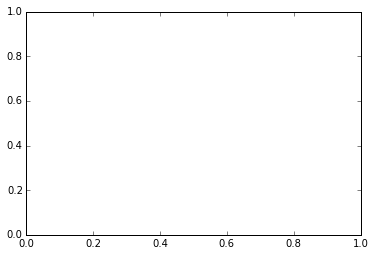

In [340]:
plt.plot(grads, ylim=(0,1))